### Importing libraries

In [3]:
import pyreadr
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.layers import Input, Dense, LSTM, Dropout, Bidirectional

### Importing Dataset

In [4]:
# Locating file in directories rather exposing the paths

import os


def search_file(start_dir, target_file):
    for dirpath, dirnames, filenames in os.walk(start_dir):
        if target_file in filenames:
            # print("Found {} at: {}".format(target_file, os.path.join(dirpath, target_file)))
            return os.path.join(dirpath, target_file)
    # print("File '{}' not found in '{}'".format(target_file, start_dir))
    return None


start_dir = "D:\\"

Fault_free_data = search_file(start_dir, "TEP_FaultFree_Training.RData")
Fault_data = search_file(start_dir, "TEP_Faulty_Training.RData")

In [5]:
df_FaultFree = pyreadr.read_r(Fault_free_data)['fault_free_training']
df_Faulty = pyreadr.read_r(Fault_data)['faulty_training']

In [6]:
# Join both fault free and faulty dataset
DF = pd.concat([df_FaultFree, df_Faulty])
DF.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


### Preprocessing dataset

In [7]:
def SlidingWindow(df, w, s):
    X = []
    Y = []
    # Iterate through the rows of the DataFrame in steps of size s
    for i in range(0, len(df)-w, s):
        # Extract a window of width w from the DataFrame, starting at row i
        x = np.array(df.iloc[i:i+w, 3:])
        # Extract the target value (faultNumber) for the last row of the window
        y = np.array(df.iloc[i+w-1, 0])
        # Append the window and target value to the X and Y lists, respectively
        X.append(x)
        Y.append(y)

    # Convert the X and Y lists to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [8]:
w = 20
s = 10

X = []
Y = []

# Loop through all faultNumbers except 3, 9, and 15, and all simulationRuns from 1 to 50
for j in [x for x in range(0, 21) if x not in [9, 15]]:
    for i in range(1, 50):
        # Select the rows from DataFrame DF with the current faultNumber and simulationRun, and remove highly correlated columns
        df = DF[(DF['faultNumber'] == j) & (
            DF['simulationRun'] == i) & (DF['sample'] > 20)]
        # Apply sliding window with window size w and step size s to the current DataFrame
        x_temp, y_temp = SlidingWindow(df, w, s)
        # Append the resulting windowed data and target values to the X and Y lists, respectively
        X.append(x_temp)
        Y.append(y_temp)

# Convert the X and Y lists to numpy arrays, and reshape them to the correct dimensions
X = np.array(X).reshape((-1, w, x_temp.shape[-1]))
Y = np.array(Y).reshape((-1,))

In [9]:

sc = StandardScaler()

# Filter the DataFrame to only include data from the first simulation run
reduced_data = DF[DF['faultNumber'] == 0]
# Select the rows from the reduced dataset that have faultNumber equal to 0, and extract the feature values
fault_free = reduced_data[(reduced_data['faultNumber'] == 0)].iloc[:, 3:]

# Fit the StandardScaler object to the feature values of the fault-free data
sc.fit(fault_free)

StandardScaler()

In [10]:
X_sc = sc.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

c:\Users\saif_\miniconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [11]:
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc.fit(Y.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_enc = enc.transform(Y.reshape(-1, 1))

c:\Users\saif_\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X_sc, Y_enc, test_size=0.2, random_state=42)

### Preparing neural network

In [13]:

def LSTM_model(X_train, y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Define encoder layers
    encoded = Bidirectional(
        LSTM(128, activation="tanh", return_sequences=True))(input_layer)
    encoded = LSTM(128, activation="tanh")(encoded)

    # Define decoder layers
    decoded = Dense(300, activation='selu')(encoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(y_train.shape[1], activation='softmax')(decoded)

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=decoded)
    # Compile LSTM  model
    lstm_model.compile(loss='categorical_crossentropy',
                       optimizer='adam', metrics=['accuracy'])
    return lstm_model

### Training model

Epoch 1/200
134/134 [==============================] - 8s 22ms/step - loss: 0.6502 - accuracy: 0.7905 - val_loss: 0.2162 - val_accuracy: 0.9354
Epoch 2/200
134/134 [==============================] - 2s 16ms/step - loss: 0.1536 - accuracy: 0.9537 - val_loss: 0.1409 - val_accuracy: 0.9561
Epoch 3/200
134/134 [==============================] - 2s 16ms/step - loss: 0.1152 - accuracy: 0.9658 - val_loss: 0.1477 - val_accuracy: 0.9538
Epoch 4/200
134/134 [==============================] - 2s 16ms/step - loss: 0.0901 - accuracy: 0.9726 - val_loss: 0.1093 - val_accuracy: 0.9659
Epoch 5/200
134/134 [==============================] - 2s 16ms/step - loss: 0.0745 - accuracy: 0.9756 - val_loss: 0.1061 - val_accuracy: 0.9678
Epoch 6/200
134/134 [==============================] - 2s 16ms/step - loss: 0.0668 - accuracy: 0.9784 - val_loss: 0.1142 - val_accuracy: 0.9631
Epoch 7/200
134/134 [==============================] - 2s 16ms/step - loss: 0.0590 - accuracy: 0.9811 - val_loss: 0.1043 - val_accuracy:

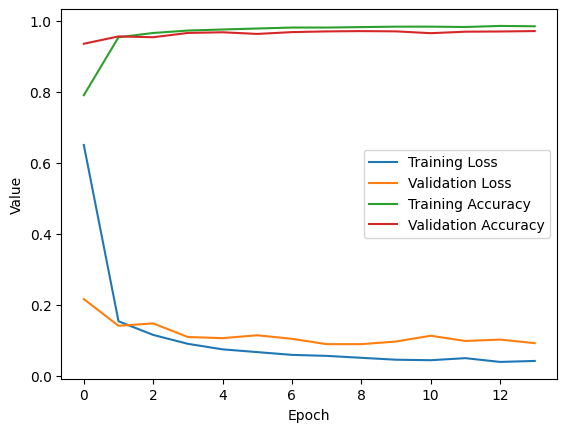

In [14]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model = LSTM_model(x_train, y_train)
history = model.fit(x_train, y_train, epochs=200, batch_size=256,
                    validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

### Evaluating the model

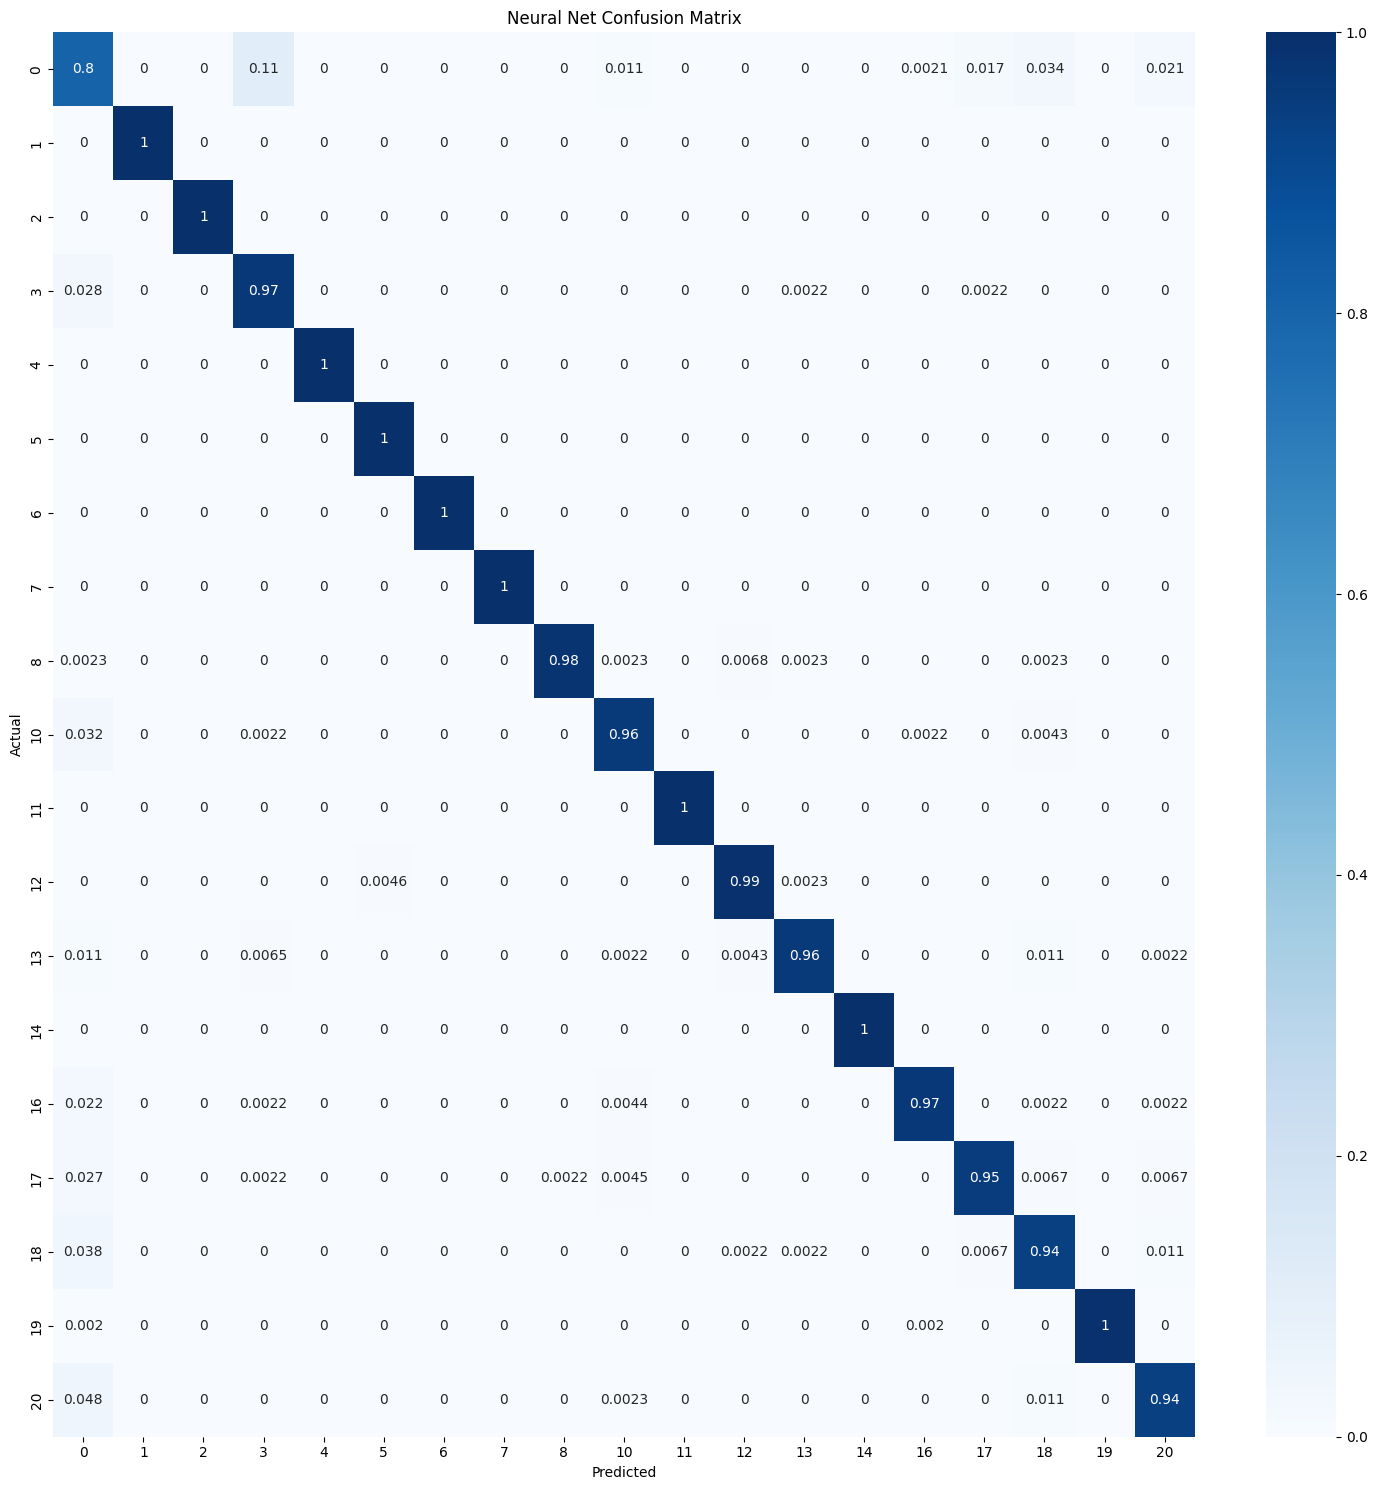

Neural Net accuracy_score: 0.9711650712117674


In [15]:
# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels([str(x) for x in range(0, 21) if x not in [9, 15]])
    ax.set_yticklabels([str(x) for x in range(0, 21) if x not in [9, 15]])
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()


y_pred = enc.inverse_transform(model.predict(x_test, verbose=0))
y_true = enc.inverse_transform(y_test)

# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_true, y_pred, 'Neural Net Confusion Matrix')
print("Neural Net accuracy_score:", accuracy_score(y_true, y_pred))

### Realtime fault prediction

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


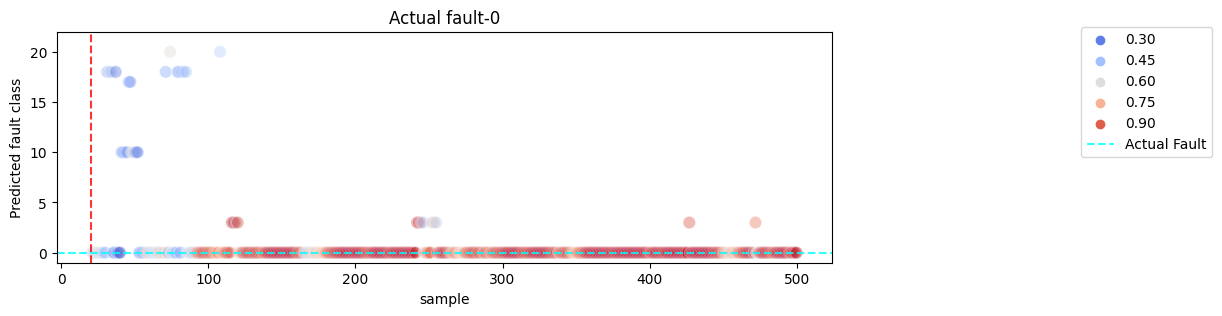

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


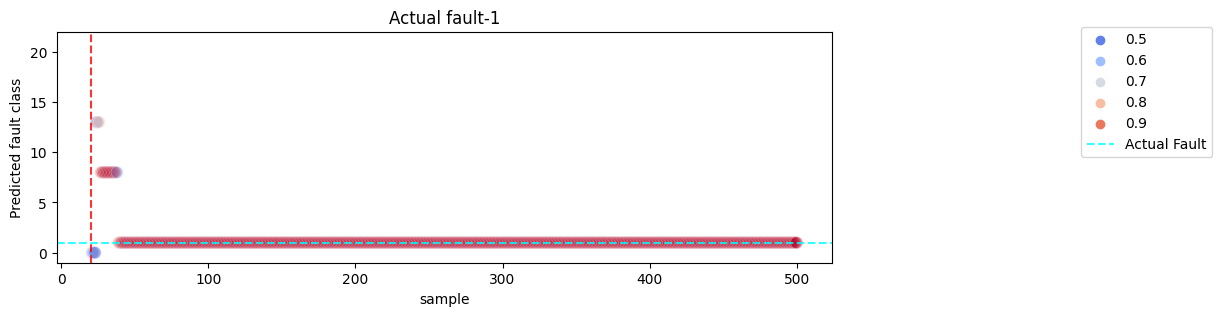

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


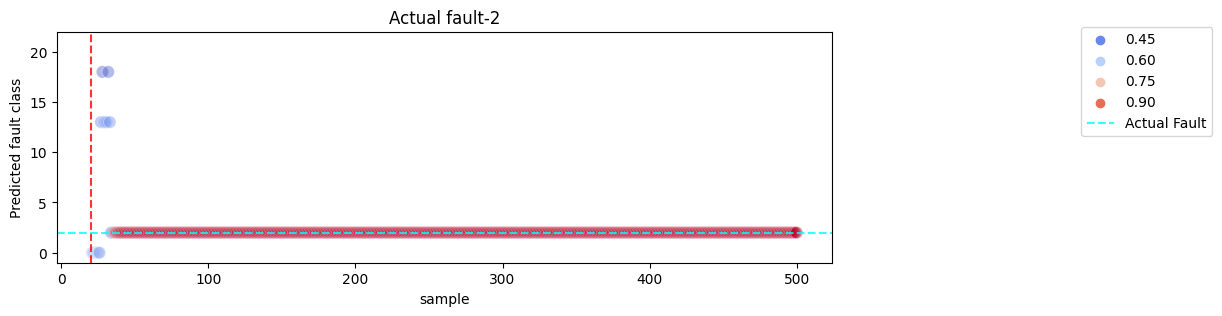

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


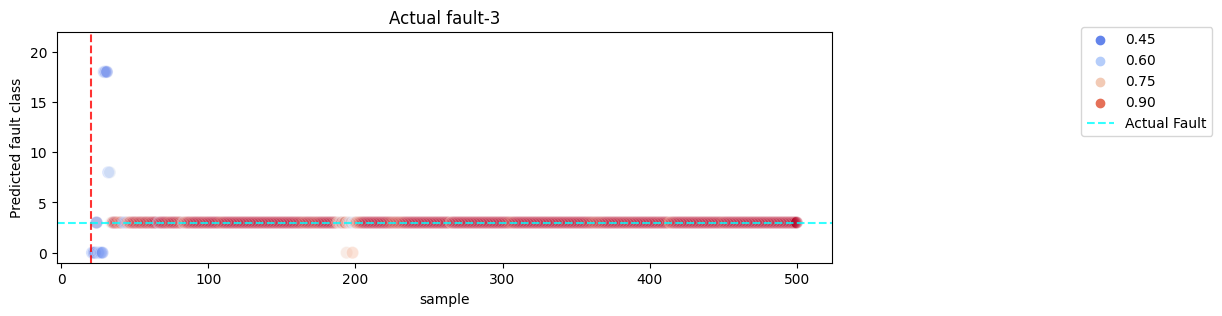

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


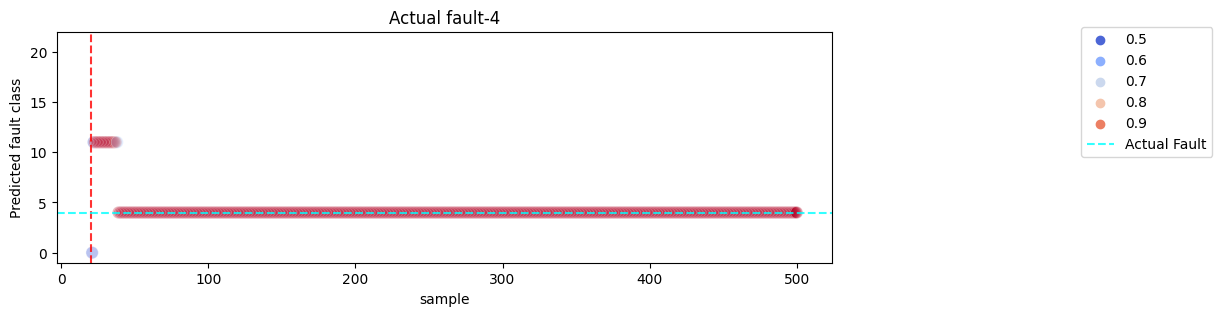

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


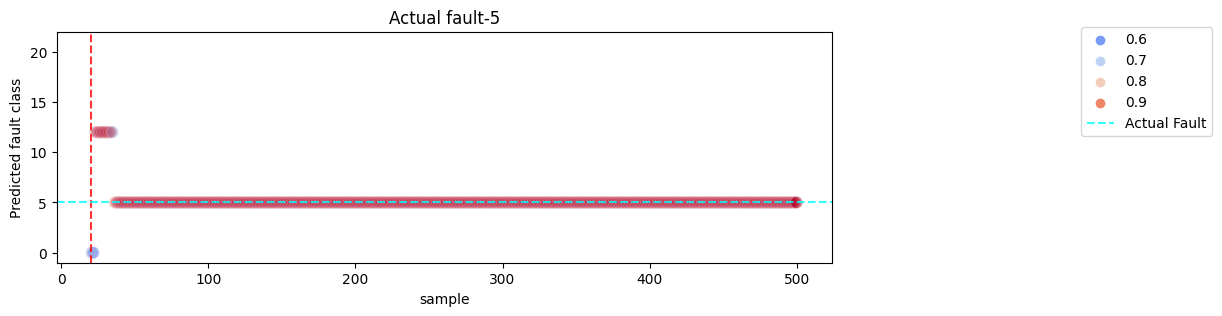

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


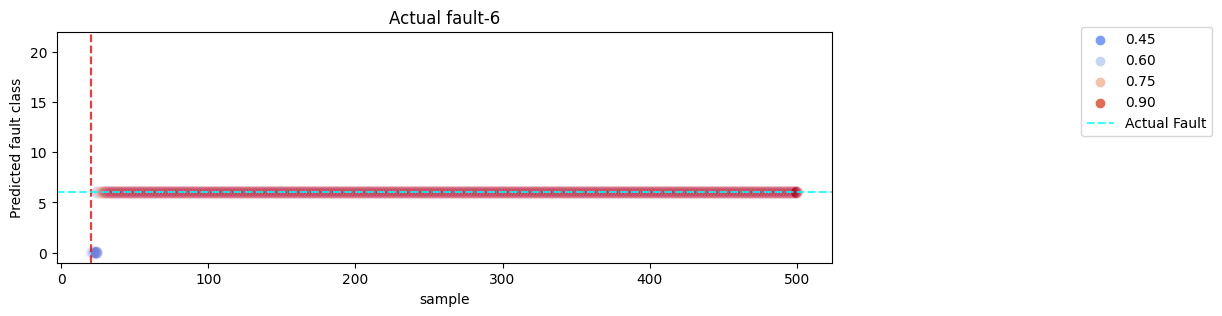

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


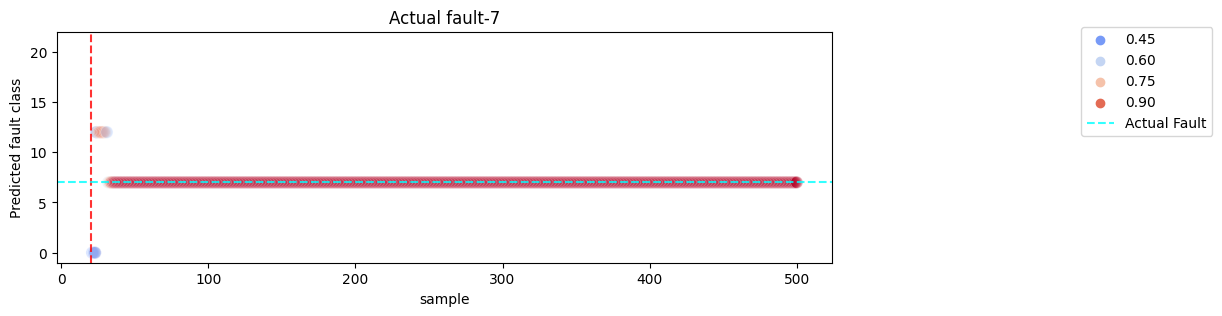

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


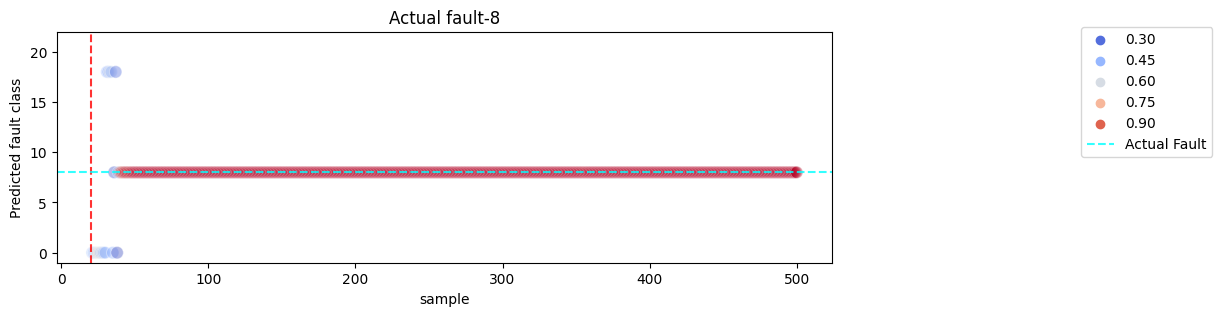

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


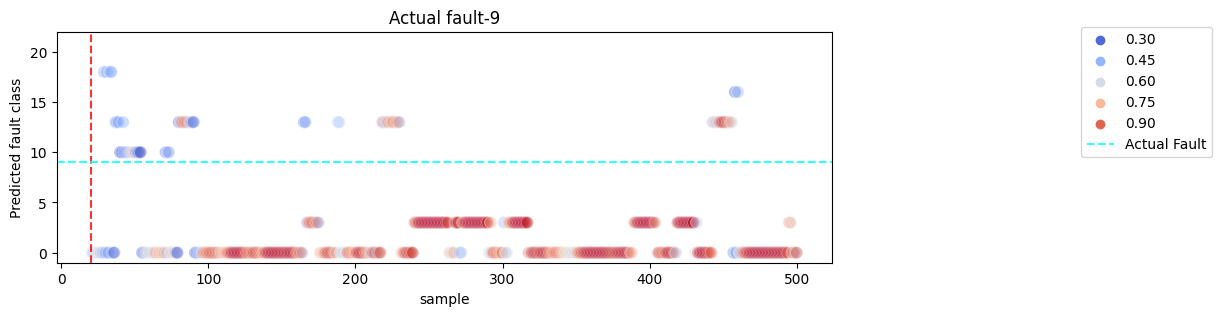

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


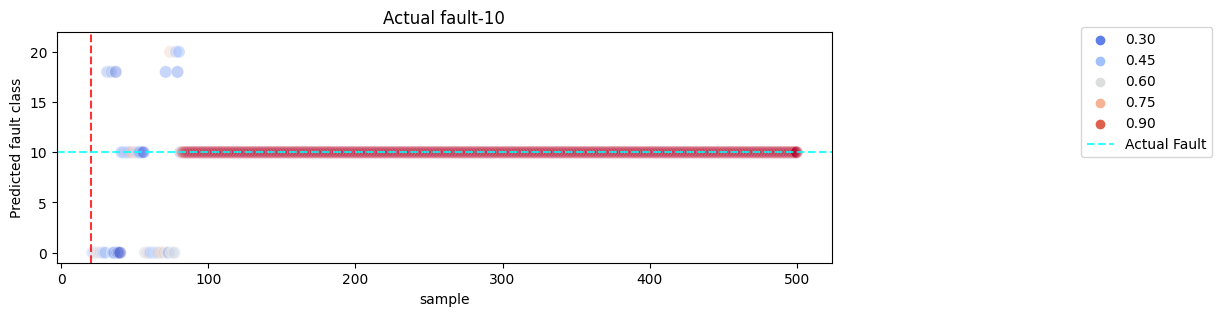

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


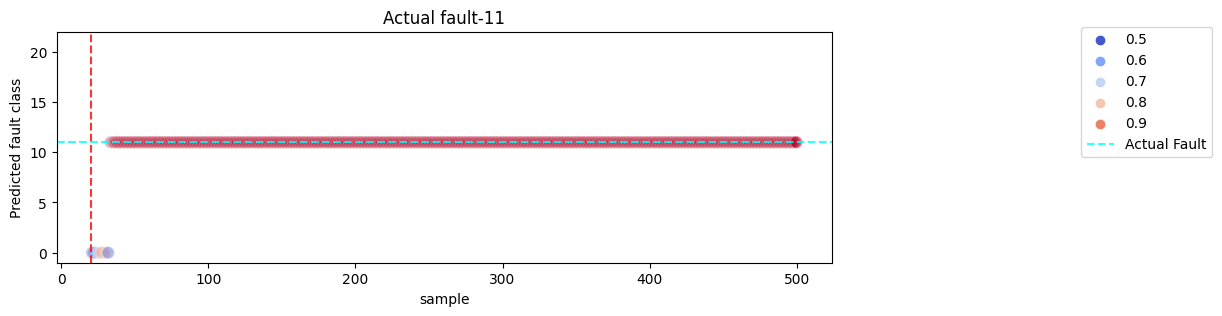

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


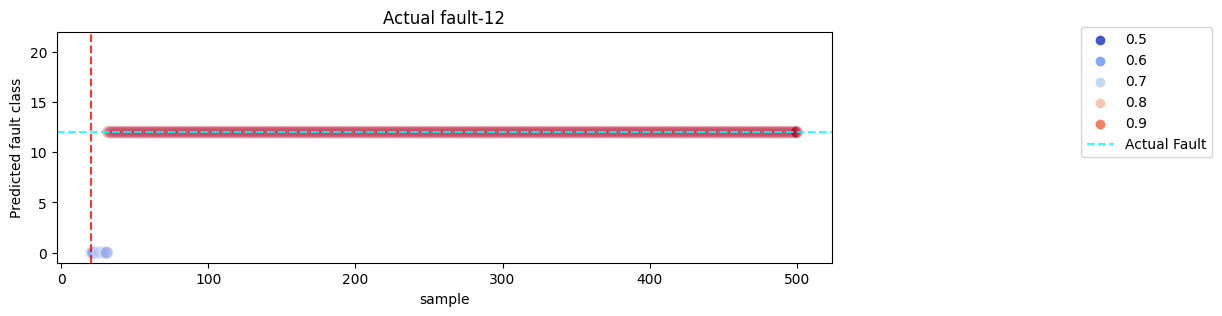

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


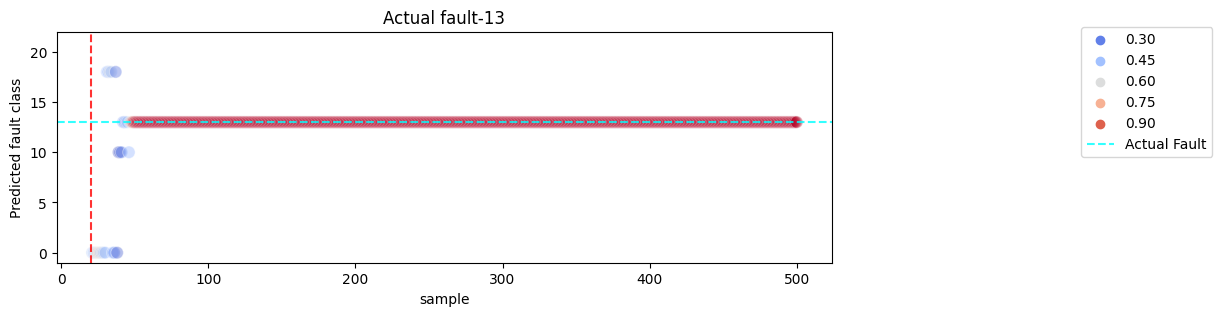

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


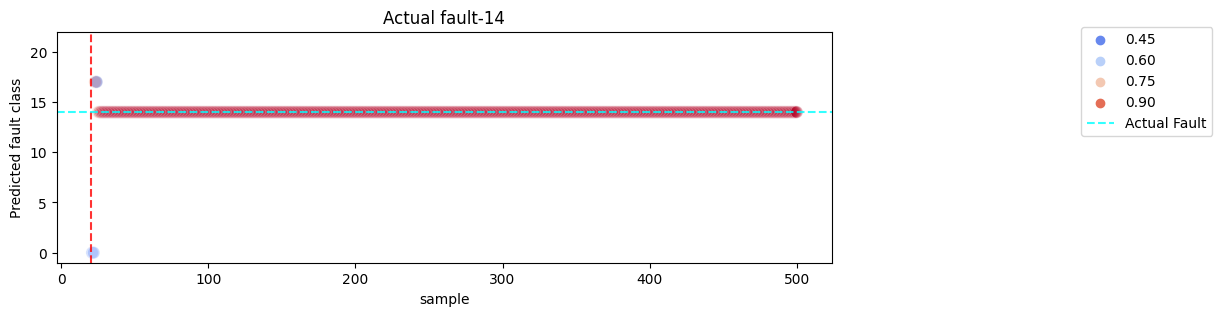

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


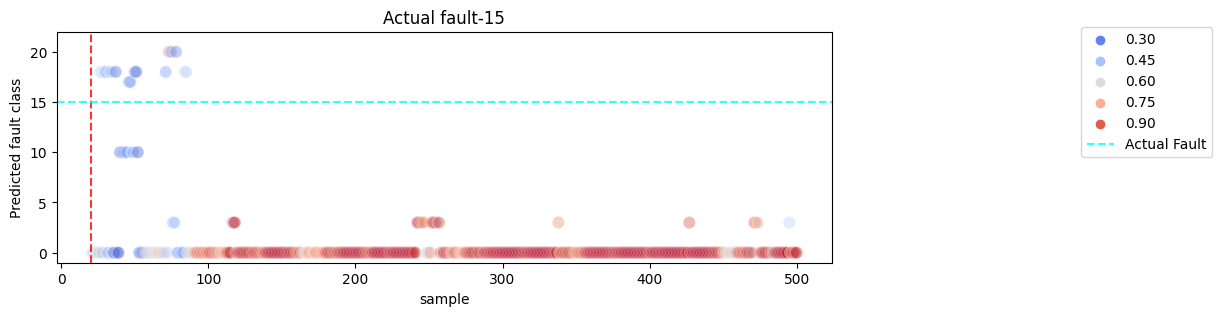

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


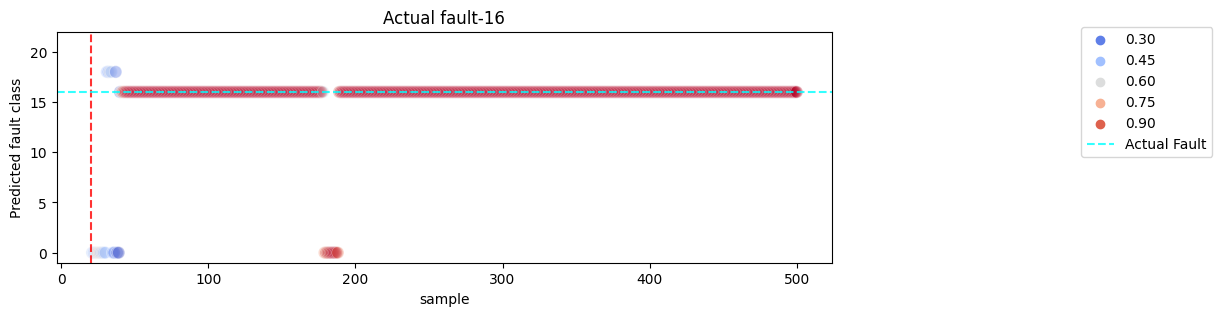

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


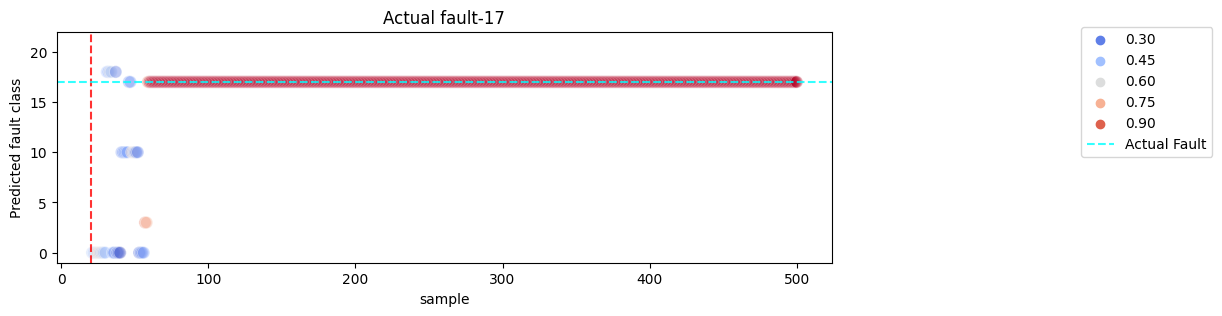

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


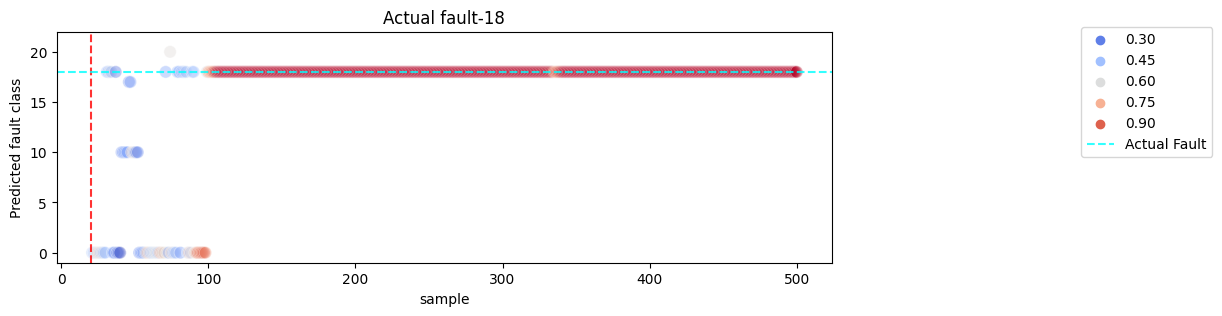

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


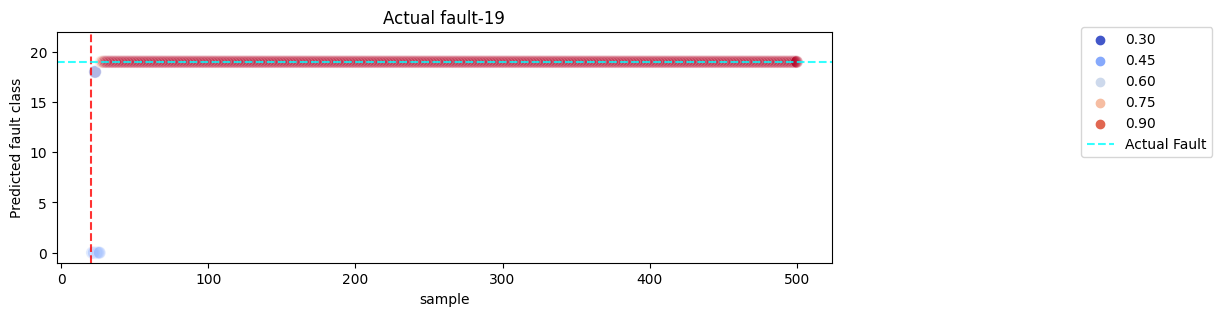

c:\Users\saif_\miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


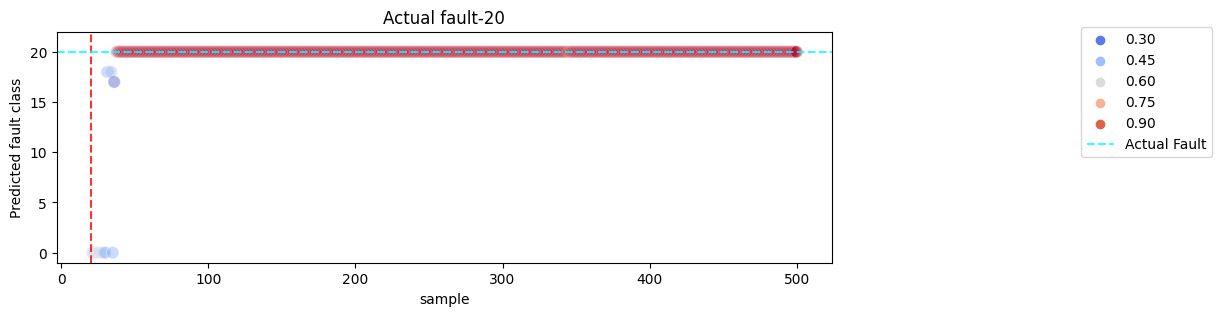

In [16]:
for F_num in range(0, 21):
    # select the fault data each fault
    df_new = DF[(DF['faultNumber'] == F_num) & (DF['simulationRun'] == 1)]
    # normalize the data
    df_new.iloc[:, 3:] = sc.transform(df_new.iloc[:, 3:])

    # create sliding window data
    x_new, y_new = SlidingWindow(df_new, w=20, s=1)

    # predict fault class and probability for each sliding window
    y_pred = enc.inverse_transform(model.predict(x_new, verbose=0))
    y_proba = np.max(model.predict(x_new, verbose=0), axis=1)

    # plot the results
    f, ax = plt.subplots(figsize=(10, 3))
    sns.scatterplot(x=df_new['sample'][w:], y=y_pred[:, 0], hue=y_proba,
                    palette="coolwarm", s=80, alpha=0.4, vmin=0, vmax=1)
    plt.axvline(20, c='r', alpha=0.8, linestyle='--')
    plt.axhline(F_num, c='cyan', alpha=0.8,
                label='Actual Fault', linestyle='--')
    plt.legend(bbox_to_anchor=(1.5, 1.05))
    plt.ylabel('Predicted fault class')
    plt.ylim([-1, 22])
    plt.title(f'Actual fault-{F_num}')
    plt.show()

In [20]:
#This code calculates the accuracy of the LSTM model for each fault number in the dataset.
Accuracy=[]
#For each fault number in the dataset
for Fnum in [x for x in range(0,21) if x not in [3,9,15]]:
    # Get data for a random simulation run
    df_new= DF[(DF['faultNumber']==F_num) & (DF['simulationRun']==np.random.randint(1,500))]
    # Preprocess data using StandardScaler
    df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])
    
    # Generate sliding windows from data
    x_new,y_true =  SlidingWindow(df_new,w=w,s=1)
    # Predict fault using LSTM model
    y_pred = enc.inverse_transform(model.predict(x_new, verbose=0))
    # Calculate accuracy of predicted fault
    acc = accuracy_score(y_true, y_pred)
    print(f'The accuracy for Fault_num={Fnum} is {acc}')
    # Append accuracy to list
    Accuracy.append(acc)
    
print("#"*20)
print(f'The overall accuracy is {np.mean(Accuracy)}')

The accuracy for Fault_num=0 is 0.9895833333333334
The accuracy for Fault_num=1 is 0.9333333333333333
The accuracy for Fault_num=2 is 0.94375
The accuracy for Fault_num=4 is 0.95625
The accuracy for Fault_num=5 is 0.8958333333333334
The accuracy for Fault_num=6 is 0.8854166666666666
The accuracy for Fault_num=7 is 0.85625
The accuracy for Fault_num=8 is 0.9041666666666667
The accuracy for Fault_num=10 is 0.9354166666666667
The accuracy for Fault_num=11 is 0.9541666666666667
The accuracy for Fault_num=12 is 0.9708333333333333
The accuracy for Fault_num=13 is 0.93125
The accuracy for Fault_num=14 is 0.9291666666666667
The accuracy for Fault_num=16 is 0.96875
The accuracy for Fault_num=17 is 0.85625
The accuracy for Fault_num=18 is 0.8729166666666667
The accuracy for Fault_num=19 is 0.9229166666666667
The accuracy for Fault_num=20 is 0.9458333333333333
####################
The overall accuracy is 0.9251157407407408


### t-SNE visualisation to analyze model clustering performance

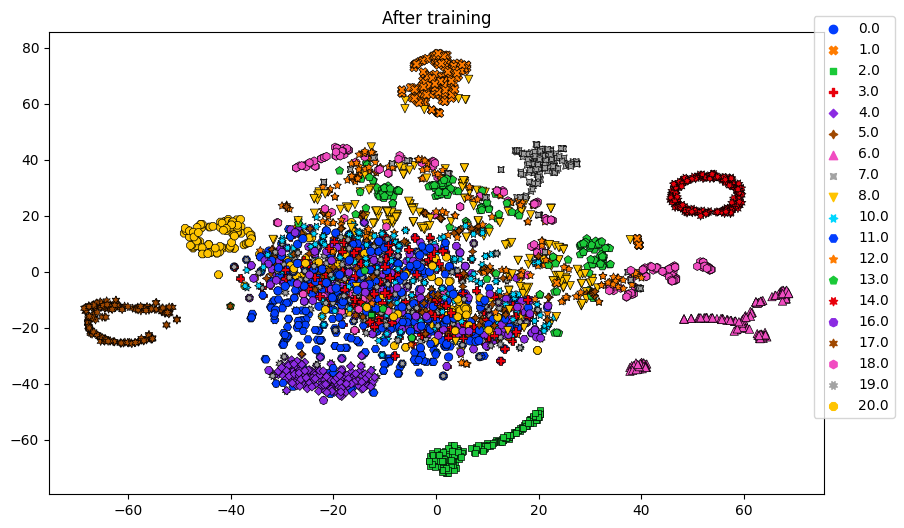

In [17]:
# Reduce the dimensionality of the training data using t-SNE
x_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(
    x_train[::10, :].reshape(len(x_train[::10, :]), -1))
# Retrieve the original labels for the reduced data
y_label = enc.inverse_transform(y_train[::10, :]).reshape(-1)
# Create a scatterplot of the reduced data with different colors for each class
f, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=x_embedded[:, 0], y=x_embedded[:, 1], hue=y_label,
                style=y_label, palette="bright", edgecolor='black')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('After training')
plt.show()

In [18]:
# Define intermediate model to get the output of the second to last layer
intermediate_model = Model(inputs=model.input, outputs=model.layers[-2].output)
intermediate_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 52)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 256)          185344    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
Total params: 421,164
Trainable params: 421,164
Non-trainable params: 0
_____________________________________________________

108/108 [==============================] - 1s 6ms/step


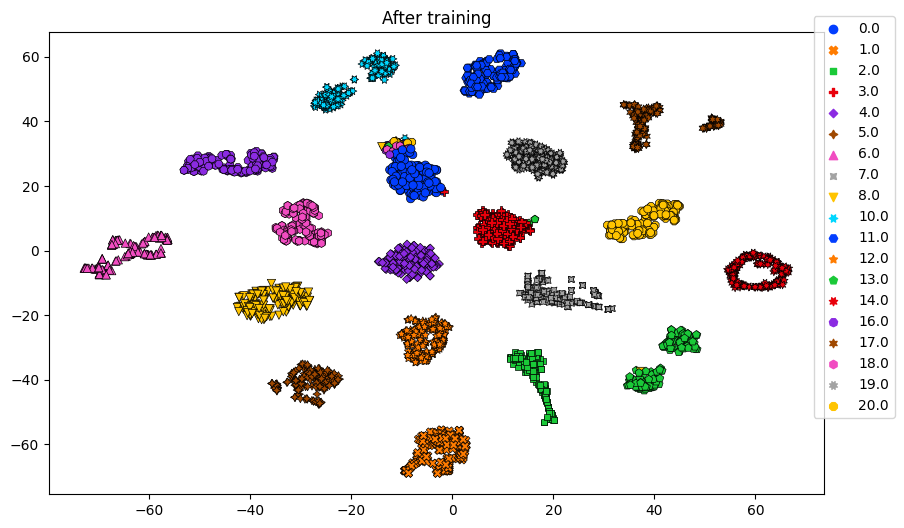

In [19]:
# Get the intermediate output for every 10th data point in the training set
x_inter = intermediate_model.predict(x_train[::10, :])
# Use t-SNE to reduce the dimensionality of the intermediate output to 2D
x_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(x_inter)
# Get the true labels for every data point in the training set
y_label = enc.inverse_transform(y_train[::10, :]).reshape(-1)
# Create a scatter plot of the embedded data, colored by the true labels
f, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=x_embedded[:, 0], y=x_embedded[:, 1], hue=y_label,
                style=y_label, palette="bright", edgecolor='black')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('After training')
plt.show()